In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("winequality-white.csv", sep=";")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [20]:
X = data.drop("quality", axis=1).values
y = data["quality"].values

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
from sklearn.kernel_ridge import KernelRidge
estimator = KernelRidge(alpha=1.0, # valeur par défaut
                       kernel='rbf', # noyau gaussien de la forme exp(- gamma * ||x-y||^2)
                       gamma=0.01)
estimator.fit(X_train_scaled, y_train)

KernelRidge(alpha=1.0, gamma=0.01, kernel='rbf')

In [24]:
y_test_pred = estimator.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE = %.3f" % rmse)

RMSE = 0.750


Pour visualiser les prédictions, on va utiliser un nuage de points.

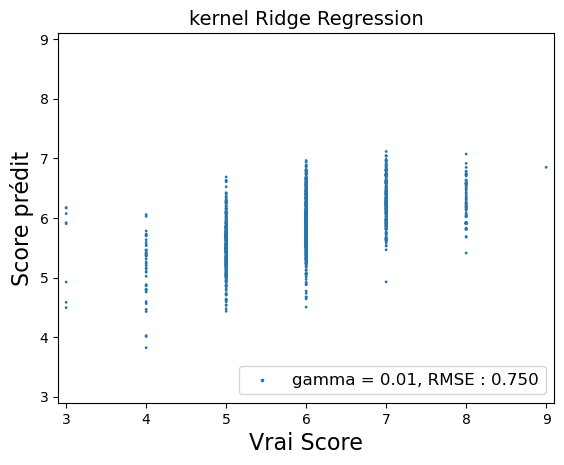

In [25]:
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_test_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()

# Affichons le nuage de points
import matplotlib.pyplot as plt
plt.scatter([k[0] for k in keys],
           [k[1] for k in keys],
           s = [sizes[k] for k in keys],
           label = "gamma = 0.01, RMSE : {:.3f}".format(rmse))

# Etiquetage
plt.xlabel("Vrai Score", fontsize=16)
plt.ylabel("Score prédit", fontsize=16)
plt.title("kernel Ridge Regression", fontsize=14)

# limites des axes
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

plt.show()

In [26]:
from sklearn.kernel_ridge import KernelRidge
estimator50 = KernelRidge(alpha=1.0, # valeur par défaut
                       kernel='rbf', # noyau gaussien de la forme exp(- gamma * ||x-y||^2)
                       gamma=50)
estimator50.fit(X_train_scaled, y_train)
y_test_pred50 = estimator50.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred50))
print("RMSE = %.3f" % rmse)

RMSE = 5.305


Clairement, la valeur de gamma influe fortement sur la précision du modèle. On va devoir optimiser les hyperparamètres du modèle, avec une validation croisée (comme d'habitude)

In [27]:
from sklearn.model_selection import GridSearchCV

params_grid = {"alpha" : np.logspace(-2, 2, 5),
               "gamma" : np.logspace(-2, 1, 4)}

score = "neg_mean_squared_error"

grid = GridSearchCV(KernelRidge(kernel='rbf'),
                   params_grid,
                   n_jobs = -1,
                   cv = 5,
                   scoring = score,
                   verbose = 1)

grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'), n_jobs=-1,
             param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
results = pd.DataFrame(grid.cv_results_)
results = results.drop(columns = [col for col in results.columns if "split" in col]).sort_values("rank_test_score")
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,params,mean_test_score,std_test_score,rank_test_score
0,3.486934,0.200483,0.286412,0.089628,0.01,0.01,"{'alpha': 0.01, 'gamma': 0.01}",-0.488088,0.024998,1
4,4.165615,0.600459,0.181796,0.027731,0.1,0.01,"{'alpha': 0.1, 'gamma': 0.01}",-0.495096,0.023271,2
8,3.486204,0.421825,0.163398,0.034243,1.0,0.01,"{'alpha': 1.0, 'gamma': 0.01}",-0.521207,0.018266,3
5,3.505402,0.408156,0.179000,0.067353,0.1,0.1,"{'alpha': 0.1, 'gamma': 0.1}",-0.565731,0.044586,4
12,3.688090,0.125060,0.141208,0.024904,10.0,0.01,"{'alpha': 10.0, 'gamma': 0.01}",-0.609530,0.023524,5
1,3.758253,0.410700,0.253399,0.090170,0.01,0.1,"{'alpha': 0.01, 'gamma': 0.1}",-0.642148,0.037014,6
9,3.291783,0.398713,0.180207,0.072297,1.0,0.1,"{'alpha': 1.0, 'gamma': 0.1}",-0.682844,0.054654,7
16,2.979724,0.214902,0.137544,0.011618,100.0,0.01,"{'alpha': 100.0, 'gamma': 0.01}",-0.828124,0.036209,8
13,3.159365,0.360391,0.162214,0.024189,10.0,0.1,"{'alpha': 10.0, 'gamma': 0.1}",-1.404515,0.099001,9
17,2.913883,0.143665,0.163692,0.030254,100.0,0.1,"{'alpha': 100.0, 'gamma': 0.1}",-3.979396,0.178260,10


In [30]:
grid.best_params_

{'alpha': 0.01, 'gamma': 0.01}

In [31]:
y_test_pred_cv = grid.predict(X_test_scaled)

In [32]:
rmse_cv = np.sqrt(mean_squared_error(y_test, y_test_pred_cv))

print("RMSE CV = {:.3f}".format(rmse_cv))
print("neg mean squared error = {:.3f}".format(-1*rmse_cv**2))

RMSE CV = 0.721
neg mean squared error = -0.520
